This annex is simply a detailed compilation of the methods presented in the accompanying article
“Modelling the syncronisation pattern of Photinus carolinus in silico using cellular automata”. For
more complete descriptions of what we are doing, please refer to that article.

First, we import the necessary modules:

In [1]:
import numpy as np                   # Supports common numeric operations
import matplotlib.pyplot as plt      # Graphic representation library
from matplotlib import animation     # Creates animations (which we can then display as HTML, gif, etc) 
from IPython import display          # To display things on Jupyter; in this case, the animations
import scipy as sp                   # Scientific Python Library
import scipy.stats as stats          # Stats calculator from SciPy
import warnings                      # Supress nasty SPARK warnings
import pandas as pd                  # Python Data Analysis Library
import datetime                      # Show the time the script takes to run

from pyspark.sql import SparkSession # Machine Learning Library to understand component importance
from pyspark.ml.feature import VectorAssembler # Assemble a vector from raw data
from pyspark.ml.regression import DecisionTreeRegressor # Our machine learning method
from pyspark.ml.evaluation import RegressionEvaluator # An evaluator for our method

And then we define the updating function:

In [2]:
def time_step(initial_conditions, treshold = 0.25):
    
    # Mira que me gusta python, pero me he tirado 4 HORAS pa enterarme
    # de que habia que hacer copy en vez de =, PERO QUE HORRÓ
    new = initial_conditions.copy()
    old = initial_conditions.copy()
    
    # Loop over the matrix and update the values
    for x in range(initial_conditions.shape[0]):
        for y in range(initial_conditions.shape[1]):
            new[x,y] = (old[x,y]==0)  # The pacemaker: invert all values       

            # We can define the neigbors as:
            xup=x+1;   xdw=x-1
            yup = y+1; ydw =y-1

            # To deal with edges, we set their values as same
            if (x==0):  xdw=x
            if (x==initial_conditions.shape[0] - 1): xup=x
            if (y==0):  ydw=y
            if (y==initial_conditions.shape[1] - 1): yup=y

            # Gather neighbor's consensus through the median of its values
            net = np.median([ old[xdw,y],  old[xup,y],   old[x,yup], 
                              old[x,ydw],  old[xdw,ydw], old[xup,yup],
                              old[xdw,yup],old[xup,ydw] ])

            # Reset if if treshold is met and neighbors are overall on
            if ( new[x,y]==1 and np.random.uniform(0,np.nextafter(1,2)) > treshold and net==1 ):
                new[x,y] = 0
    return new

We first define the function that extracts the data for out analysis:

In [3]:
def count_elements(each_timestep):
    
    # Label binary islands
    labels, number = sp.ndimage.measurements.label(each_timestep)
    labels_i, number_i = sp.ndimage.measurements.label(1 - each_timestep)
    
    # Count island members
    count_current = sp.ndimage.sum(x, labels, range(number + 1))
    count_inverse = sp.ndimage.sum(1-x, labels_i, range(number_i + 1))
                                   
    # Calculate params
    all_elements = np.append(count_current, count_inverse)
    number_of_components = len(all_elements)
    largest_component_size = np.sort(all_elements)[-1]
    avg_size_equilibrium = sum(all_elements) / number_of_components
                                   
    return largest_component_size, number_of_components, avg_size_equilibrium

And then we use it in the function that sees variation timestep-by-timestep:

In [4]:
def keep_track(matrix_of_matrixes, average = False, log = False):
    
    # This function assumes the matrix of matrixes passed actually exists (no size 0 allowed)
    for index, each_timestep in enumerate(matrix_of_matrixes):
        
        if index > 4: # We require at least 4 generations of no change to consider stable
            
            # Compùte largest compound at current iteration
            largest_component_size, number_of_components, avg_size_equilibrium = count_elements(each_timestep)
            
            # Two iterations away (because of ON/OFF, only 2-by-2 iterations are accounted for)
            previous_largest_size, dev, null = count_elements(matrix_of_matrixes[index-2])
            
            # And three iterations away
            old_largest_size, dev, null = count_elements(matrix_of_matrixes[index-4])
            
            if largest_component_size == previous_largest_size == old_largest_size:   
                # Return the adequate values
                if average == True:
                    return largest_component_size, number_of_components, index-4, avg_size_equilibrium
                else: # Due to return's properties, this else is just cosmetic
                    return largest_component_size, number_of_components, index-4
    
    # This generates a small distorsion on the data, but otherwise the code might fail (1% of runs)
    if average == True:
        return 0,0,0,0
    else:
        return 0,0,0

With the main pieces of code defined, we can start our investigations:

## Lattice Size

We run a simulation of 95 latices, from sizes 5 to 100, and see the results:

In [5]:
list_of_largest, list_of_number, list_of_index = [],[],[]
for mysize in range(5, 100):
    x = np.random.choice([0, 1], size=(mysize,mysize))
    sizetype = []
    
    # Allow for 100 time steps, enough for interesting behaviour to show up
    for t in range(100): 
        sizetype.append(x)
        x = time_step(x)
        
    try:
        largest, number, index = keep_track(sizetype)
    except:
        print(keep_track(sizetype))
    
    # Generate lists
    list_of_largest.append(largest); list_of_number.append(number)
    list_of_index.append(index)

For the data visualization part, we have decided to try to fit the data to a linear model using SciPy's ```linregress``` package, extracting the R² and the p-value parameters to mathematically see how well this correlate. We thus first define the ```plot_graph``` function:

In [6]:
def plot_graph(fig, ax, x_data, y_data, color, x_label, y_label, x_textcoords, y_textcoords, fit = 'linear'):
    res = stats.linregress(x_data, y_data)
    ax.plot(x_data, y_data, 'o', label=x_label, color = color)
    if fit == 'linear': ax.plot(x_data, res.intercept + res.slope*x_data, color, label='Fitted line')
    if fit == 'exponential': exp = np.polyfit(x_data, np.log(y_data), 1)
    if fit == 'exponential': ax.plot(x_data, np.exp(exp[1])*np.exp(x_data*exp[0]), color, label='Fitted EXP')
    ax.legend()
    string = f"R²: {res.rvalue**2}" + "\n"+ f"p-value: {res.pvalue}"
    props = dict(boxstyle='round', facecolor=color, alpha=0.2)
    ax.text(x_textcoords, y_textcoords, string, fontsize=14, transform=ax.transAxes, verticalalignment='top', bbox=props)
    ax.set_xlabel(y_label, size=12)
    ax.set_ylabel(x_label, size=12)
    ax.set_title(f"{x_label} over multiple {y_label}", size=15)

And then we plot the results:

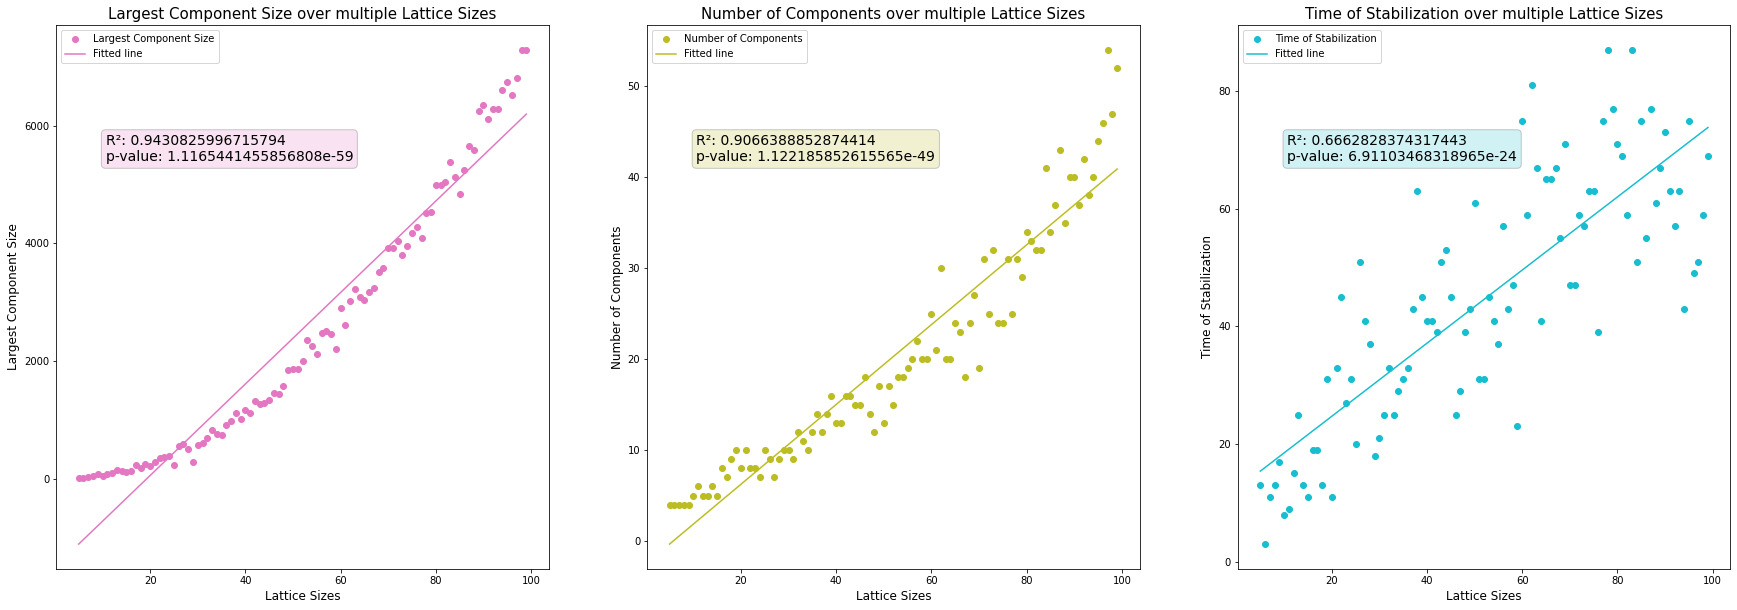

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))
plot_graph(fig, ax[0], range(5,100), list_of_largest, 'tab:pink', "Largest Component Size", "Lattice Sizes", 0.1, 0.8)
plot_graph(fig, ax[1], range(5,100), list_of_number, 'tab:olive', "Number of Components", "Lattice Sizes", 0.1, 0.8)
plot_graph(fig, ax[2], range(5,100), list_of_index, 'tab:cyan', "Time of Stabilization", "Lattice Sizes", 0.1, 0.8)
plt.savefig("lattice_size.png"); plt.show()

## Influenceability by the neighbors' consensus

For this analysis, we chose 100 linearly spaced treshold values between 0 and 1:

In [8]:
list_of_largest, list_of_number, list_of_index = [],[],[]
initial_conditions = np.random.choice([0, 1], size=(25,25))
for param in np.linspace(0,1, num=100):
    x = initial_conditions.copy() # So that the list updates in a sensefull way
    sizetype = []
    
    # Allow for 100 time steps, enough for interesting behaviour to show up
    for t in range(100): 
        sizetype.append(x)
        x = time_step(x, treshold = param)
        
    try:
        largest, number, index = keep_track(sizetype)
    except:
        print(keep_track(sizetype))
    
    # Generate lists
    list_of_largest.append(largest); list_of_number.append(number)
    list_of_index.append(index)

And we plot the scatter plots, just as we did before; I would have preferred to fins some different graph types, but, to be quite honest, scatterplots are the best way of plotting correlation between two variables.

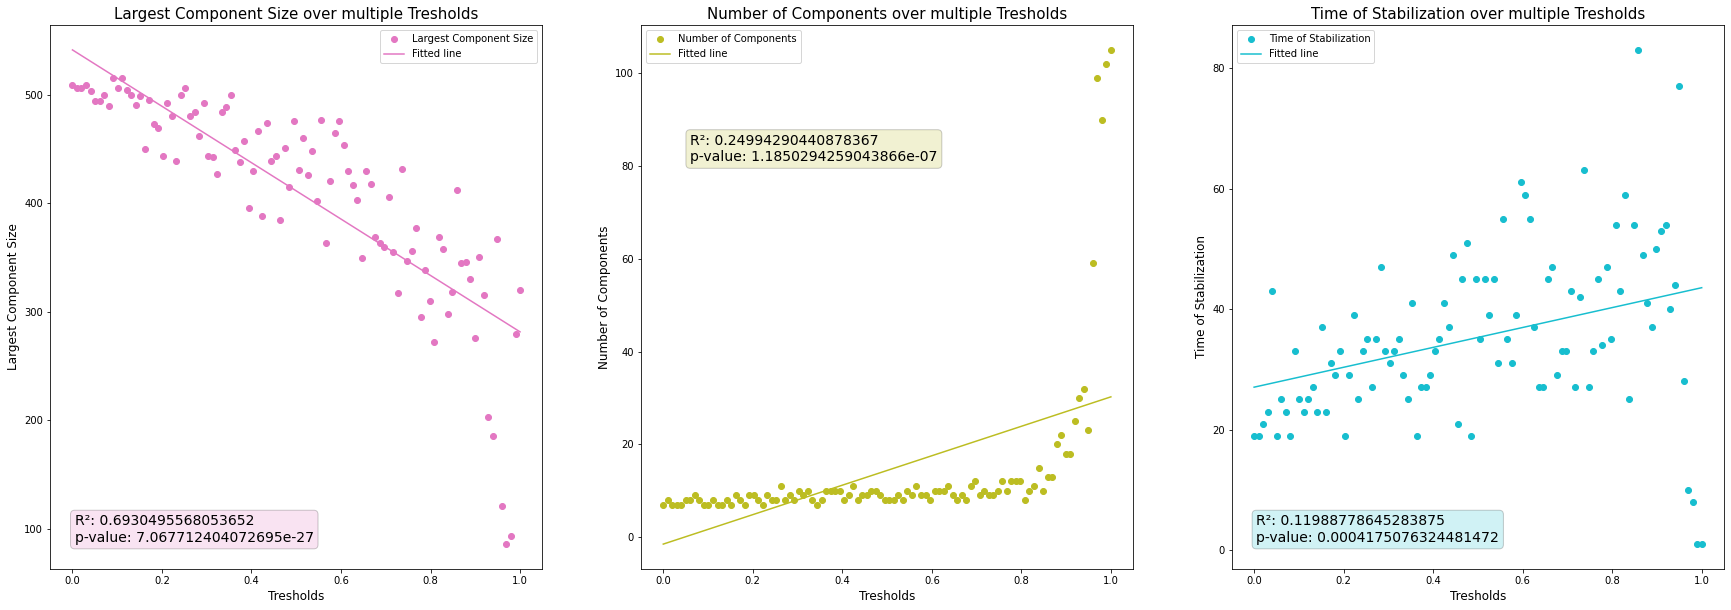

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))
plot_graph(fig, ax[0], np.linspace(0,1, num=100), list_of_largest, 
           'tab:pink', "Largest Component Size","Tresholds",0.05,0.1)
plot_graph(fig, ax[1], np.linspace(0,1, num=100), list_of_number, 
           'tab:olive', "Number of Components", "Tresholds",0.1,0.8)
plot_graph(fig, ax[2], np.linspace(0,1, num=100), list_of_index, 
           'tab:cyan', "Time of Stabilization", "Tresholds",0.05,0.1)
plt.savefig("treshold_1.png"); plt.show()

To make sense of the remaining, non-outlier data, can slice it to keep out those outliers and re-make the graphs:

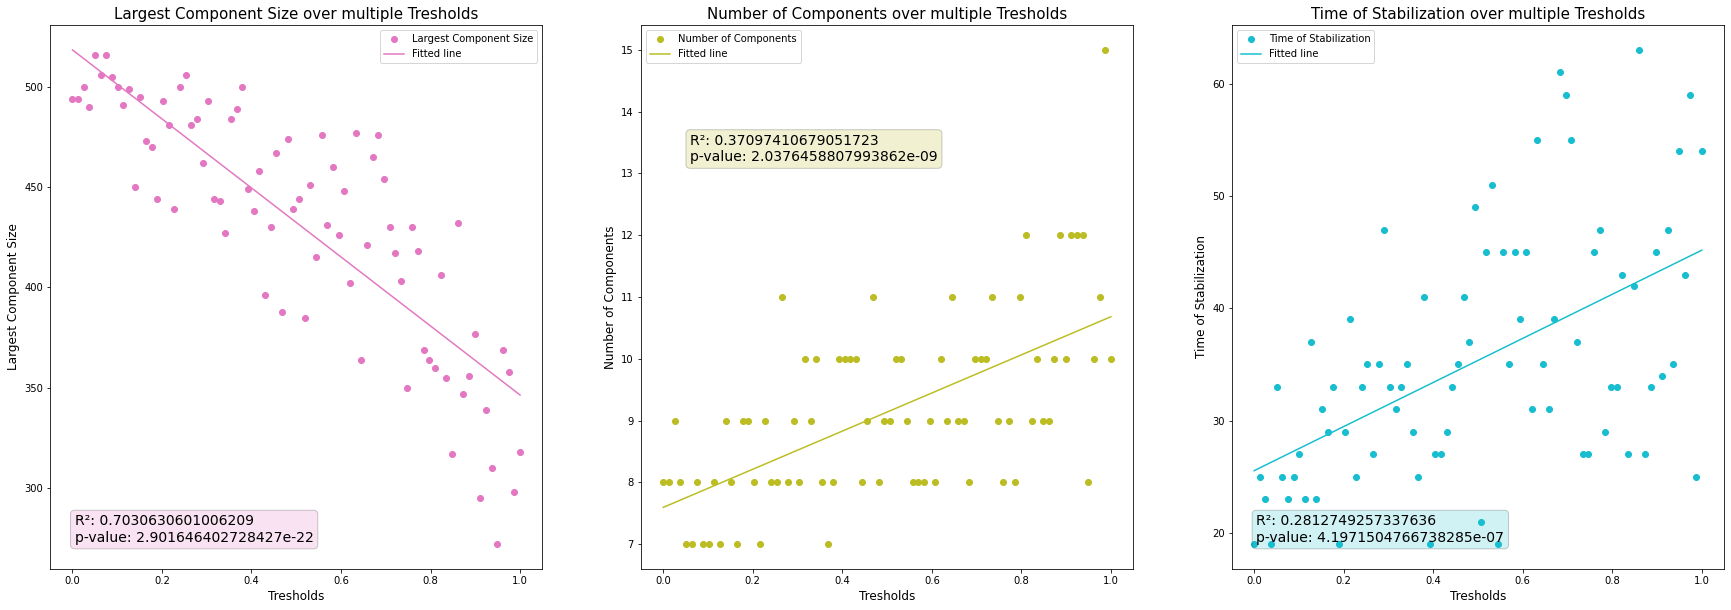

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))
plot_graph(fig, ax[0], np.linspace(0,1, num=80), list_of_largest[5:85], 
           'tab:pink', "Largest Component Size","Tresholds",0.05,0.1)
plot_graph(fig, ax[1], np.linspace(0,1, num=80), list_of_number[5:85], 
           'tab:olive', "Number of Components", "Tresholds",0.1,0.8)
plot_graph(fig, ax[2], np.linspace(0,1, num=80), list_of_index[5:85], 
           'tab:cyan', "Time of Stabilization", "Tresholds",0.05,0.1)
plt.savefig("treshold_2.png"); plt.show()

## Initial Frequency of each type of individuals

We run the 100 simulations with evenly spaced p values from 0 to 1:

In [11]:
list_of_largest, list_of_number, list_of_index = [],[],[]
for prob in np.linspace(0,1, num=100):
    x = np.random.choice([0, 1], size=(25,25), p=(1-prob,prob))
    sizetype = []
    
    # Allow for 100 time steps, enough for interesting behaviour to show up
    for t in range(100): 
        sizetype.append(x)
        x = time_step(x)
        
    try:
        largest, number, index = keep_track(sizetype)
    except:
        print(keep_track(sizetype))
    
    # Generate lists
    list_of_largest.append(largest); list_of_number.append(number)
    list_of_index.append(index)

And we plot the same data:

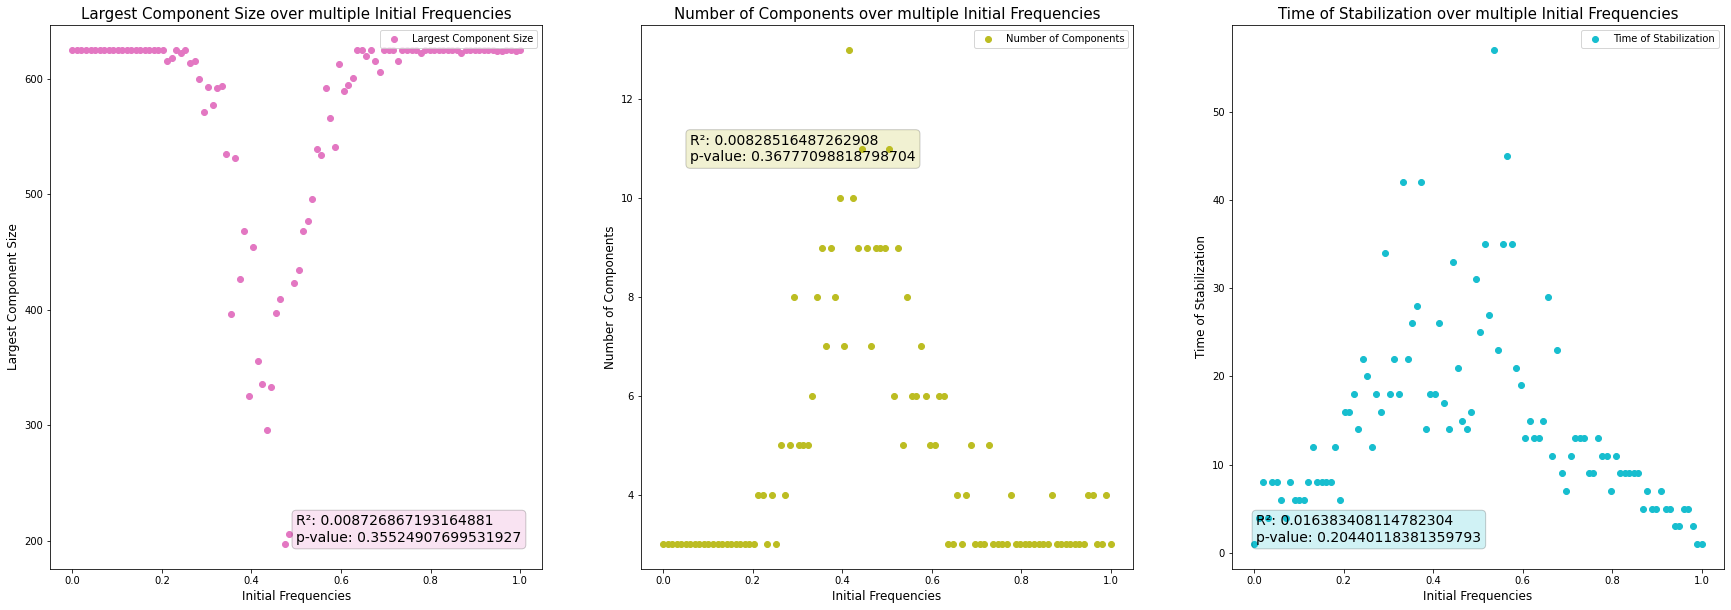

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))
plot_graph(fig, ax[0], np.linspace(0,1, num=100), list_of_largest, 
           'tab:pink', "Largest Component Size","Initial Frequencies",0.5,0.1, fit="")
plot_graph(fig, ax[1], np.linspace(0,1, num=100), list_of_number, 
           'tab:olive', "Number of Components", "Initial Frequencies",0.1,0.8, fit="")
plot_graph(fig, ax[2], np.linspace(0,1, num=100), list_of_index, 
           'tab:cyan', "Time of Stabilization", "Initial Frequencies",0.05,0.1, fit="")
plt.savefig("initial_frequencies.png"); plt.show()

## The final question

To perform this analysis, we have run 8000 different experiments, in which we have varied the following parameters:
* The lattice size between 10 and 30: in this way, we avoided very small sizes, with artefacts such as perfect synchronisations at the beginning, and very large ones, which would increase the computation time incredibly. 
* The proportions of initial values, with p-values between 0 and 1, up to 20 values: in this case, we have not trimmed the values because we have seen that the linear dependence is equally bad regardless of whether we take extremes or not.
* Tresholds between 0 and 1, up to 20 values: again, we have decided not to trim the initial values, and keeping 20 values allows us to keep the computation time from going even higher.
* The number of generations has been kept at a maximum of 80 in all cases, since we have seen, by analysing the graphs of the previous simulations, that this number is almost never exceeded, even for lattices larger than 30x30.

*(beware that this code might take 2h plus to run)*

In [13]:
print(datetime.datetime.now())
assay_data = pd.DataFrame(columns=['Size', 'Prob of 1', 'Treshold', 'Average cluster size', 'Time to Equilibrium'])
for mysize in range(10, 30):
    for prob in np.linspace(0.1,0.9, num=20):
        for param in np.linspace(0.1,0.9, num=20):
            x = np.random.choice([0, 1], size=(mysize,mysize), p=(1-prob,prob))
            sizetype = []
            
            for t in range(80): 
                sizetype.append(x)
                x = time_step(x, treshold = param)
            largest, number, index, average = keep_track(sizetype, average = True)
            
            assay_data.loc[len(assay_data)] = [mysize, prob, param, average, index]
print(datetime.datetime.now())

2022-01-08 05:55:35.319946
2022-01-08 07:23:34.951578


Now, we have our data ready! We can proceed to import pyspark, the python wrapper for SPARK; we have set up a warnings catcher because we would like to skip SPARK's unnecessary warnings, but you can keep it if you will.

In [14]:
with warnings.catch_warnings(record=True):
    spark = SparkSession.builder.appName('seedfinder').getOrCreate()

22/01/08 07:23:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


We can now create a SPARK dataframe using our pandas dataframe, and preprocess the data, generating a train and test subset at random:

In [16]:
df = spark.createDataFrame(assay_data)

vectorAssembler = VectorAssembler(inputCols = ['Size','Prob of 1','Treshold'], outputCol = 'features')
output = vectorAssembler.transform(df)
train, test = output.randomSplit([0.7, 0.3])

We want to run our "features imporance" analysis both for the 'Average cluster size' and 'Time to Equilibrium' columns; thus:

In [20]:
# First, we fit our models:
average_model = DecisionTreeRegressor(featuresCol ='features', labelCol = 'Average cluster size').fit(train)
time_model = DecisionTreeRegressor(featuresCol ='features', labelCol = 'Time to Equilibrium').fit(train)

# And we see the importance of each feature assignated by the model:
print("The features importance for the 'Average cluster size' were:")
print(average_model.featureImportances)
print("The features importance for the 'Time to Equilibrium' were:")
print(time_model.featureImportances)

The features importance for the 'Average cluster size' were:
(3,[0,1,2],[0.6049323655163993,0.27029697566423555,0.12477065881936514])
The features importance for the 'Time to Equilibrium' were:
(3,[0,1,2],[0.21023709618151912,0.3162554166283455,0.47350748719013547])


One last question could be made: how good is our model at, in fact, predicting things? How meaningful are the results we can obtain using our model? Are the predicions good, and thus the results significative, or do they not make any sense? We can make the following calculations:

In [17]:
# We make some predictions
average_predictions = average_model.transform(test)
time_predictions = time_model.transform(test)

#We create some evaluators
average_eval_rmse = RegressionEvaluator(labelCol='Average cluster size', predictionCol="prediction", metricName="rmse")
time_eval_rmse = RegressionEvaluator(labelCol='Time to Equilibrium', predictionCol="prediction", metricName="rmse")

average_eval_r2 = RegressionEvaluator(labelCol='Average cluster size', predictionCol="prediction", metricName="r2")
time_eval_r2 = RegressionEvaluator(labelCol='Time to Equilibrium', predictionCol="prediction", metricName="r2")

# We apply them
average_rmse = average_eval_rmse.evaluate(average_predictions);average_r2 = average_eval_r2.evaluate(average_predictions)
time_rmse = time_eval_rmse.evaluate(time_predictions); time_r2 = time_eval_r2.evaluate(time_predictions)

# And show the results
print(f"For 'Average cluster size', the RMSE was {average_rmse}, and the R² was {average_r2}")
print(f"For 'Time to Equilibrium', the RMSE was {time_rmse}, and the R² was {time_r2}")

For 'Average cluster size', the RMSE was 28.828547842945333, and the R² was 0.7914107986023979
For 'Time to Equilibrium', the RMSE was 11.127137925528865, and the R² was 0.47268128181030655


## Bonus Point: Animations

Using the knowledge from Task 6, here is a nice animation function that will allow you to visualise the evolution of the fireflies depending on the initial conditions you choose. An equivalent mp4 video has been sent along with the answer in case you don't feel like running the code yourself.

In [18]:
def animate_firefly(initial_conditions, treshold = 0.25,
                    frames = 100, interval = 200, dpi = 10, save = False):
    X = np.asarray(initial_conditions).astype(bool)
    X_blank = np.zeros_like(X)
    fig = plt.figure(figsize=initial_conditions.shape, dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1], xticks=[], yticks=[], frameon=False)
    im = ax.imshow(X, cmap='GnBu', interpolation='nearest')
    im.set_clim(-0.05, 1) 
    
    def init(): #This plots the background of each frame
        im.set_data(X_blank)
        return (im,)

    def animate(i): #This generates each frame
        im.set_data(animate.X)
        animate.X = time_step(animate.X, treshold)
        return (im,)

    animate.X = X
    anim = animation.FuncAnimation(fig, animate, init_func=init,frames=frames, interval=interval)
    if save == True : anim.save('fireflies.gif', writer='imagemagick') 
    
    video = anim.to_html5_video(); html = display.HTML(video)
    display.display(html); plt.close()

In [19]:
animate_firefly(np.random.choice([0, 1], size=(50,50)), save = True)